In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
# from keras.preprocessing.image import load_img, img_to_array, array_to_img
#モデルの可視化
#from tensorflow.python.keras.utils.vis_utils import plot_model

from keras.utils.vis_utils import plot_model
from keras.models import load_model	
import glob
import MVTecAD_loaddata as mv

In [4]:
img_rows = 256
img_cols = 256
channels = 3

# 入力画像の形状（64 x 64 x 3) //カラー画像
img_shape = (img_rows, img_cols, channels)

# noiseベクトルサイズ（生成器へのINPUT)
z_dim = 100
X_train, X_test, X_test_good, X_test_error, y_train, y_tg, y_te, y_test = mv.bottle()
X_train = (X_train)/0.5

In [5]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 8 * 8, input_dim=z_dim))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32,kernel_size=5,strides=2,input_shape=img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64,kernel_size=5,strides=2,input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128,kernel_size=5,strides=2,input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
generator = build_generator(z_dim)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [9]:
# losses = []
# accuracies = []

def train(X_train, epochs, batch_size):
    # Labels for real images: all ones
    for epoch in range(epochs):
        print("epoch=", epoch)
        for i in range(0, len(X_train), batch_size):
            # -------------------------
            #  Train the Discriminator
            # -------------------------
            # Get a random batch of real images
            imgs = X_train[i:i+batch_size]
            real = np.ones((len(imgs), 1))
            # Labels for fake images: all zeros
            fake = np.zeros((len(imgs), 1))
            # Generate a batch of fake images
            z = np.random.normal(0, 1, (len(imgs), 100))
            gen_imgs = generator.predict(z, verbose=1)
            # Train Discriminator
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(imgs, real)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            discriminator.trainable = False
            d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
            # ---------------------
            #  Train the Generator
            # ---------------------
            # Generate a batch of fake images
            z = np.random.normal(0, 1, (len(imgs), 100))
            gen_imgs = generator.predict(z, verbose=1)
            # Train Generator
            g_loss = gan.train_on_batch(z, real)
            # Output training progress
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(epoch + 1, d_loss, 100.0 * accuracy, g_loss))
    return gan, generator

In [10]:
train_gan, train_generator = train(X_train, epochs=10, batch_size=32)

epoch= 0
1/1 [==============================] - 1s 724ms/step
1 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.139483]
epoch= 1
1/1 [==============================] - 1s 709ms/step
2 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.421903]
epoch= 2
1/1 [==============================] - 1s 713ms/step
3 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.352242]
epoch= 3
1/1 [==============================] - 1s 723ms/step
4 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.003151]
epoch= 4
1/1 [==============================] - 1s 724ms/step
5 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.004178]
epoch= 5
1/1 [==============================] - 1s 708ms/step
6 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.283552]
epoch= 6
1/1 [==============================] - 1s 716ms/step
7 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.036212]
epoch= 7
1/1 [==============================] - 1s 728ms/step
8 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.246151]
epoch= 8
1/1 [==============================] - 1s 709ms/step
9 

In [11]:
z = np.random.normal(0, 1, (200, 100))
gen_imgs = generator.predict(z)

7/7 [==============================] - 7s 923ms/step


In [12]:
fake = gen_imgs / np.max(gen_imgs)*255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


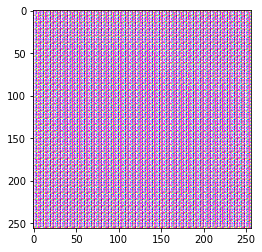

In [14]:
plt.imshow(fake[0])